In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, Photulator, StandardScaler

In [3]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model.pkl', 'rb') as f:
    speculator = pickle.load(f)
speculator.network.eval();

In [4]:
noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [5]:
# y_test = np.random.multivariate_normal(mean=[6, 0], cov=[[0.5, 0.3], [0.3, 0.1]], size=3000)
y_test1 = np.random.multivariate_normal(mean=[6, -1], cov=[[0.7, 0.], [0., 0.2]], size=2500)
y_test2 = np.random.multivariate_normal(mean=[5, 1.5], cov=[[0.7, 0.], [0., 0.3]], size=2500)
#y_test2 = np.random.multivariate_normal(mean=[6, 0], cov=[[-0.7, 0.3], [0.3, -0.1]], size=1500)
y_test = np.vstack([y_test1, y_test2])
y_stellar_mass = torch.normal(10, 0.4, size=(len(y_test), 1)).to('cuda')
y_redshift = torch.normal(0.1, 0.02, size=(len(y_test), 1)).to('cuda')
#torch.ones(size=(len(y_test), 1)).to('cuda') * 10.0 
y_test = Tensor(y_test).to('cuda')
x_test = speculator.predict_mag(y_test, 
                                log_stellar_mass=y_stellar_mass, 
                                redshift=y_redshift,
                                filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
                                noise=noise, noise_model_dir=noise_model_dir,
                               ).cpu().detach().numpy()
x_test = Tensor(x_test).to('cuda')

x_test_clean = speculator.predict_mag(y_test, 
                                log_stellar_mass=y_stellar_mass, 
                                redshift=y_redshift,
                                filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
                                noise=None,
                               ).cpu().detach().numpy()
x_test_clean = Tensor(x_test_clean).to('cuda')

# figure = corner.corner(np.hstack([y_test.cpu().detach().numpy(), 
#                                   y_stellar_mass.cpu().detach().numpy(),
#                                   y_redshift.cpu().detach().numpy()]), 
#                        quantiles=[0.16, 0.5, 0.84], 
#                        labels=['tage', 'log tau', 'log M*', 'redshift'],
#                        smooth=0.7,
#                        show_titles=True, 
#                        title_kwargs={"fontsize": 12}, 
#                        hist_kwargs={'density': True})

In [6]:
Y_truth = torch.hstack([y_test, y_stellar_mass, y_redshift])

In [7]:
filelist = os.listdir('./nde_theta_SNR10_new/')#[:6]

In [8]:
NDE_list = [pickle.load(open('./nde_theta_SNR10_new/' + file, 'rb')) for file in filelist]

In [9]:
samples = torch.dstack([NDE.sample(2000) for NDE in NDE_list])

[[<matplotlib.lines.Line2D at 0x2b504b31ac40>],

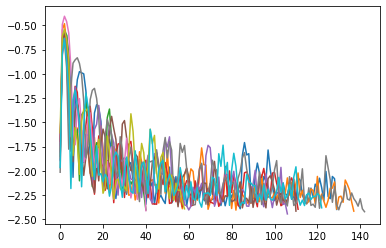

In [10]:
[plt.plot(NDE.train_loss_history) for NDE in NDE_list]

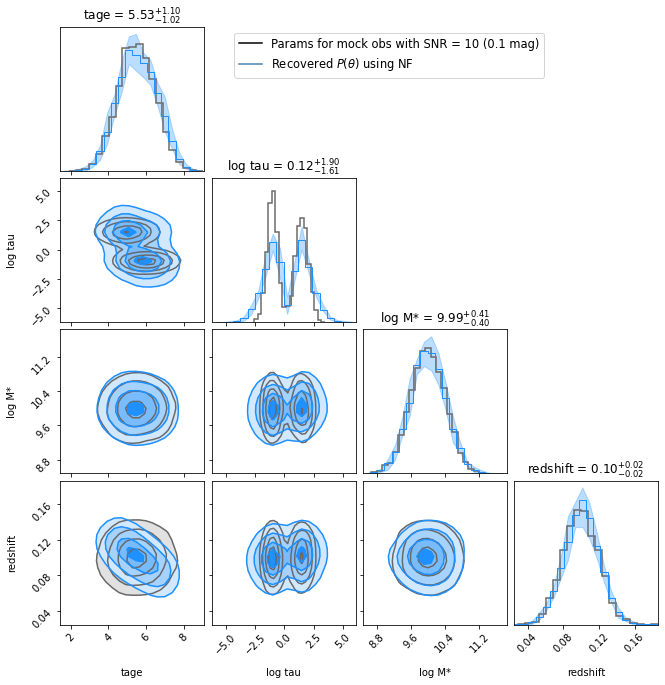

In [11]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs with SNR = 10 (0.1 mag)')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=20,
                       smooth=1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True, 'lw': 1.5}, plot_datapoints=False)

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                        fig=figure, labels=labels, bins=20,
                        color='dodgerblue',
                        smooth=1, fill_contours=True,
                        show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True, 'lw': 1.}, plot_datapoints=False)
ax = nf_plot.get_axes()[2]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [12]:
from geomloss import SamplesLoss

samples = torch.vstack([NDE.sample(500) for NDE in NDE_list])
L = SamplesLoss(loss="sinkhorn", p=2, blur=0.001, scaling=0.95) # very close to Wasserstein loss
np.log10(L(Y_truth, samples).item()) # The distance in theta space

-0.9033730646340654

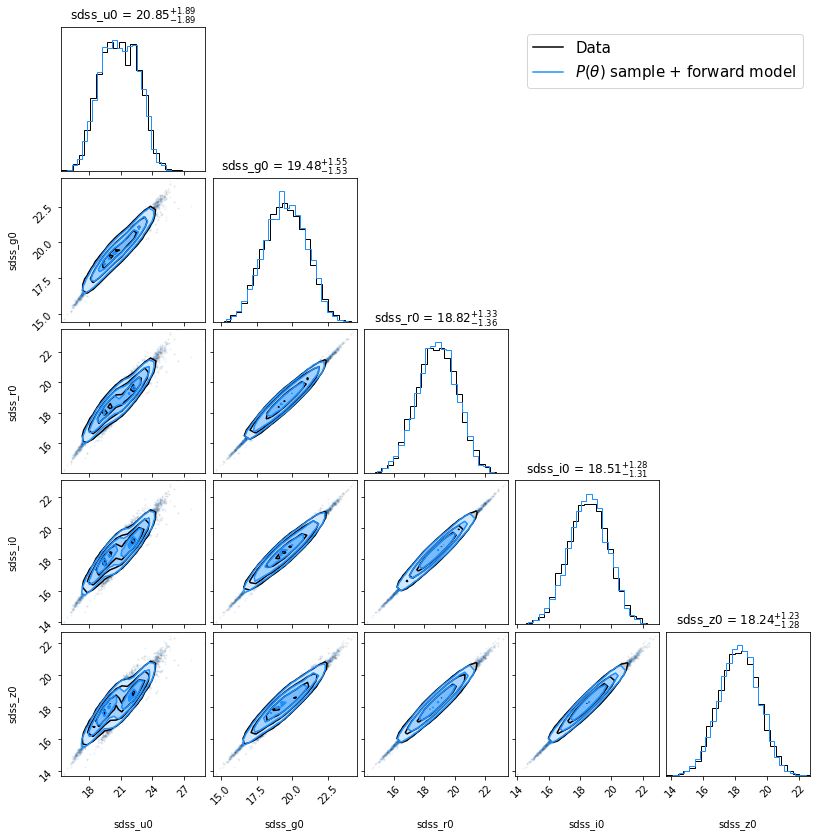

In [14]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(x_test.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, 
                       hist_kwargs={'density': True, 'lw': 1.}, 
                       title_kwargs={"fontsize": 12},
                       plot_datapoints=True)


nf_plot = corner.corner(speculator._predict_mag_with_mass_redshift(samples.swapaxes(0, 1).reshape(4, -1).T,  
                                                                   noise=noise, 
                                                                   noise_model_dir=noise_model_dir,
                                                                  ).cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.7, fill_contours=True,
                  show_titles=False, title_kwargs={"fontsize": 12},
                        hist_kwargs={'density': True, 'lw': 1.}, 
                        plot_datapoints=True)

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))